(odu_v2)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 求职搜索 VII: 带学习的搜索

```{contents} 目录
:depth: 2
```

除了Anaconda中包含的库外，本讲座还需要安装以下库：

In [1]:
!pip install interpolation

## 概述

在本讲中，我们考虑对[之前研究过的](https://python.quantecon.org/mccall_model.html) McCall求职模型{cite}`McCall1970`的扩展。

我们将基于[这节课](https://python.quantecon.org/exchangeable.html)讨论的贝叶斯学习模型，该课程涉及可交换性及其与IID（独立同分布）随机变量和贝叶斯更新概念的关系。

在McCall模型中，失业劳动者需要决定何时接受一份固定工资的永久工作，这取决于：

- 他或她的贴现因子
- 失业补助金水平
- 工资报价的分布

在下面考虑的版本中，工资分布是未知的，需要通过学习来了解。

- 以下内容基于{cite}`Ljungqvist2012`第6.6节的介绍。

让我们从一些导入开始

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

from numba import jit, prange, vectorize
from interpolation import mlinterp
from math import gamma
import numpy as np
from matplotlib import cm
import scipy.optimize as op
from scipy.stats import cumfreq, beta

### 模型特点

- 具有两种状态和一个二元控制的无限期动态规划。
- 使用贝叶斯更新来学习未知分布。

## 模型

让我们首先回顾基本的McCall模型{cite}`McCall1970`，然后添加我们想要考虑的变化。

### 基本McCall模型

回想一下，{doc}`在基准模型中 <mccall_model>`，失业劳动者在每个时期都会收到一份永久工作机会，工资为$W_t$。

在时间$t$，我们的劳动者可以：

1. 接受工作机会并以固定工资$W_t$永久工作
1. 拒绝工作机会，获得失业补助$c$并在下一期重新考虑

工资序列${W_t}$是独立同分布的，由已知密度$q$生成。

劳动者的目标是最大化预期贴现收益总和$\mathbb{E} \sum_{t=0}^{\infty}\beta^t y_t$。

让$v(w)$表示刚收到工资为$w$的工作机会的失业劳动者的最优价值，并且正在

尚未决定是接受还是拒绝这个报价。

值函数 $v$ 满足递归关系

```{math}
:label: odu_odu_pv

v(w)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w')q(w') dw'
\right\}
```

最优策略具有形式 $\mathbf{1}\{w \geq \bar w\}$，其中
$\bar w$ 是一个称为*保留工资*的常数。

### 报价分布未知

现在让我们通过考虑{cite}`Ljungqvist2012`第6.6节中提出的变体来扩展这个模型。

除了以下几点外，模型与上述相同：

- 密度 $q$ 是未知的
- 劳动者通过从先验开始，并根据他/她观察到的工资报价来更新来了解 $q$

劳动者知道有两种可能的分布 $F$ 和 $G$。

这两个分布分别具有密度 $f$ 和 $g$。

就在时间开始之前，"自然"选择 $q$ 为 $f$ 或 $g$ 之一。

这就是整个序列 ${W_t}$ 将从中抽取的工资分布。

劳动者不知道自然选择了哪个分布，但劳动者知道两个可能的分布 $f$ 和 $g$。

劳动者对 $f$ 被选中的主观先验概率为 $\pi_0$。

劳动者在时间 $0$ 时对 $W_0$ 分布的主观分布是

$$
\pi_0 f + (1 - \pi_0) g
$$

劳动者在时间 $t$ 时对 $W_t$ 分布的主观信念是

$$
\pi_t f + (1 - \pi_t) g,
$$

其中 $\pi_t$ 通过以下方式更新

```{math}
:label: odu_pi_rec_2

\pi_{t+1}
= \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1 - \pi_t) g(w_{t+1})}
```

这个最后的表达式来自贝叶斯法则，该法则告诉我们

$$
\mathbb{P}\{q = f \,|\, W = w\}
= \frac{\mathbb{P}\{W = w \,|\, q = f\}\mathbb{P}\{q = f\}}
{\mathbb{P}\{W = w\}}
$$

且

$$
\mathbb{P}\{W = w\} = \sum_{\omega \in \{f, g\}} \mathbb{P}\{W = w \,|\, q = \omega\} \mathbb{P}\{q = \omega\}
$$

{eq}`odu_pi_rec_2` 的递归性使我们能够

让我们进展到递归解法。

令

$$
q_{\pi}(w) := \pi f(w) + (1 - \pi) g(w)
$$

且

$$
\kappa(w, \pi) := \frac{\pi f(w)}{\pi f(w) + (1 - \pi) g(w)}
$$

我们可以将失业劳动者的价值函数递归表示如下

```{math}
:label: odu_mvf

v(w, \pi)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw'
\right\}
\quad \text{where} \quad
\pi' = \kappa(w', \pi)
```

注意当前的猜测值 $\pi$ 是一个状态变量，因为它影响劳动者对未来报酬概率的感知。

### 参数化

遵循 {cite}`Ljungqvist2012` 第6.6节，我们的基准参数化将是：

- $f$ 是 $\operatorname{Beta}(1, 1)$
- $g$ 是 $\operatorname{Beta}(3, 1.2)$
- $\beta = 0.95$ 且 $c = 0.3$

密度函数 $f$ 和 $g$ 具有以下形状

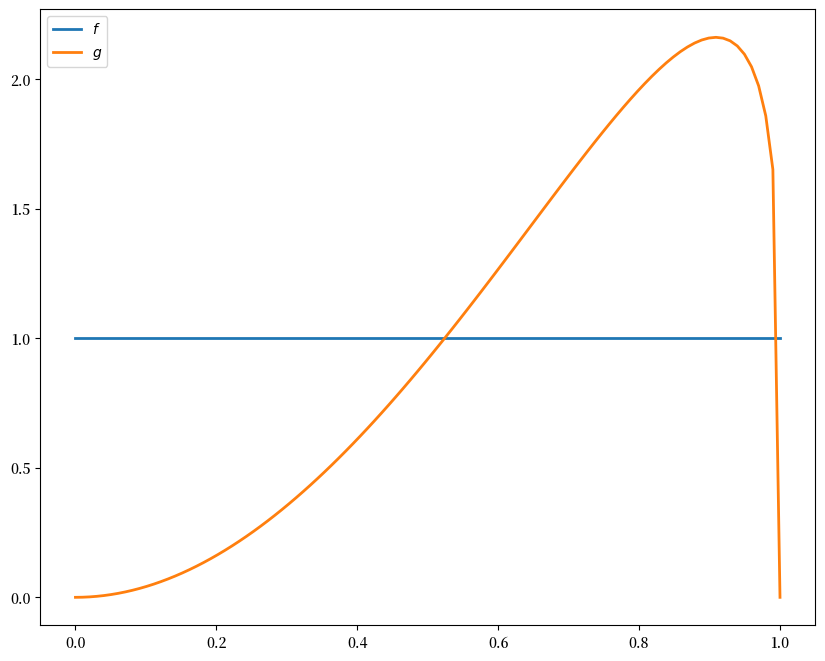

In [3]:
@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x**(a-1) * (1 - x)**(b-1)


x_grid = np.linspace(0, 1, 100)
f = lambda x: p(x, 1, 1)
g = lambda x: p(x, 3, 1.2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_grid, f(x_grid), label='$f$', lw=2)
ax.plot(x_grid, g(x_grid), label='$g$', lw=2)

ax.legend()
plt.show()

(looking-forward)=
### 展望未来

从{eq}`odu_mvf`和上述参数化可能会得到什么样的最优策略？

从直觉上讲，如果我们在$w_a$接受且$w_a\leq w_b$，那么在其他条件相同的情况下，我们也应该在$w_b$接受。

这表明策略应该是当$w$超过某个阈值$\bar w$时就接受。

但是$\bar w$应该依赖于$\pi$ — 实际上，它应该随着$\pi$的增加而减少，因为

- $f$是一个不如$g$有吸引力的分布
- 较大的$\pi$意味着$f$的权重更大，$g$的权重更小

因此，较大的$\pi$会降低劳动者对未来前景的评估，所以相对较低的当前报价变得更有吸引力。

**总结：** 我们推测最优策略的形式是$\mathbb 1{w\geq \bar w(\pi) }$，其中$\bar w$是某个递减函数。

(take-1-solution-by-vfi)=
## 方法一：通过值函数迭代求解

让我们着手解决这个模型，看看我们的结果是否符合我们的直觉。

我们首先通过值函数迭代(VFI)来求解，这是一种自然的方法，但最终证明是次优的。

`SearchProblem`类用于存储计算最优行为所需的参数和方法。

In [4]:
class SearchProblem:
    """
    一个用于存储"报价分布未知"模型特定参数化的类。
    """

    def __init__(self,
                 β=0.95,            # 贴现因子
                 c=0.3,             # 失业补偿
                 F_a=1,
                 F_b=1,
                 G_a=3,
                 G_b=1.2,
                 w_max=1,           # 最高可能工资
                 w_grid_size=100,
                 π_grid_size=100,
                 mc_size=500):

        self.β, self.c, self.w_max = β, c, w_max

        self.f = jit(lambda x: p(x, F_a, F_b))
        self.g = jit(lambda x: p(x, G_a, G_b))

        self.π_min, self.π_max = 1e-3, 1-1e-3    # 避免不稳定性
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size)

        self.mc_size = mc_size

        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)

以下函数接收这个类的实例，并返回贝尔曼算子`T`的即时编译版本，以及一个`get_greedy()`函数，用于根据值函数的猜测值`v`计算近似最优策略

In [5]:
def operator_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @jit
    def v_func(x, y, v):
        return mlinterp((w_grid, π_grid), v, (x, y))

    @jit
    def κ(w, π):
        """
        使用贝叶斯法则和当前工资观测值w更新π。
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @jit(parallel=parallel_flag)
    def T(v):
        """
        贝尔曼算子。

        """
        v_new = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0, 0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π), v)
                    integral_g += v_func(w_g[m], κ(w_g[m], π), v)
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral
                v_new[i, j] = max(v_1, v_2)

        return v_new

    @jit(parallel=parallel_flag)
    def get_greedy(v):
        """"
        以v作为值函数计算最优行动。

        """
        σ = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0, 0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π), v)
                    integral_g += v_func(w_g[m], κ(w_g[m], π), v)
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral

                σ[i, j] = v_1 > v_2  # 计算结果为1或0

        return σ

    return T, get_greedy

我们将省略对代码的详细讨论，因为后面我们会使用一个更高效的解决方案。

为了求解这个模型，我们将使用以下函数，该函数通过T进行迭代来寻找不动点

In [6]:
def solve_model(sp,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=5):

    """
    求解价值函数

    * sp是SearchProblem的一个实例
    """

    T, _ = operator_factory(sp, use_parallel)

    # 设置循环
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # 初始化v
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"第{i}次迭代的误差是{error}。")
        v = v_new

    if error > tol:
        print("未能收敛！")
    elif verbose:
        print(f"\n在第{i}次迭代后收敛。")


    return v_new

让我们看看从值函数迭代计算得出的解

第5次迭代的误差是0.6035522039048491。


第10次迭代的误差是0.10099075945406533。


第15次迭代的误差是0.022127719966830384。


第20次迭代的误差是0.0051572738895124814。


第25次迭代的误差是0.0012211008170233129。


第30次迭代的误差是0.00030489832184521504。


第35次迭代的误差是7.617146719773871e-05。

在第35次迭代后收敛。


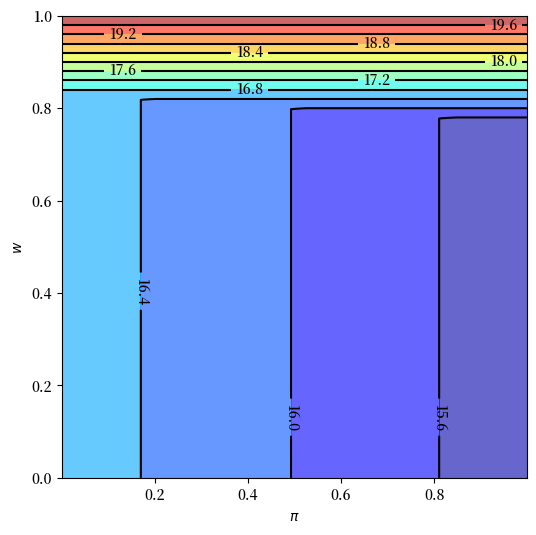

In [7]:
sp = SearchProblem()
v_star = solve_model(sp)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel=r'$\pi$', ylabel='$w$')

plt.show()

我们还将绘制最优策略

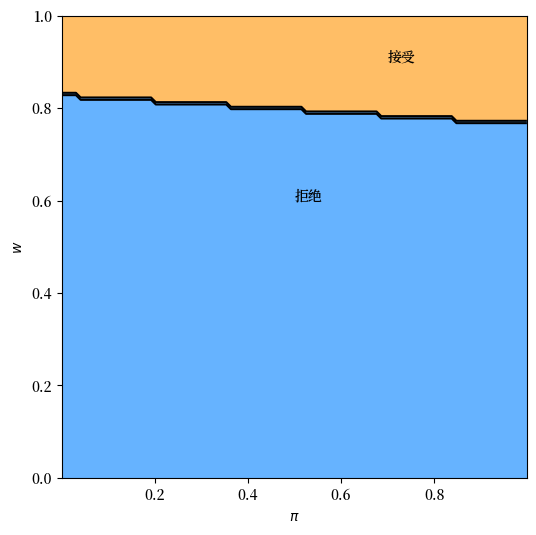

In [8]:
T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel=r'$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, '拒绝')
ax.text(0.7, 0.9, '接受')

plt.show()

结果与我们在[展望未来](looking-forward)部分的直觉相符。

- 上图中的黑线对应于那里介绍的函数$\bar w(\pi)$。
- 它如预期般呈下降趋势。

## 方案二：一个更高效的方法

让我们考虑另一种求解最优策略的方法。

我们将使用一个算子进行迭代，该算子具有与贝尔曼算子相同的收缩率，但是

- 一维而不是二维
- 没有最大化步骤

因此，该算法比值函数迭代快几个数量级。

本节说明了在编程时，一点数学分析可以带来很大帮助。

## 另一个泛函方程

首先，注意当$w = \bar w(\pi)$时，劳动者对接受和拒绝是无差异的。

因此，{eq}`odu_mvf`右侧的两个选择具有相等的值：

```{math}
:label: odu_mvf2

\frac{\bar w(\pi)}{1 - \beta}

= c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw'
```

将{eq}`odu_mvf`和{eq}`odu_mvf2`结合得到

```{math}
:label: odu_mvf3

v(w, \pi) =
\max
\left\{
    \frac{w}{1 - \beta} ,\, \frac{\bar w(\pi)}{1 - \beta}
\right\}
```

将{eq}`odu_mvf2`和{eq}`odu_mvf3`结合,我们得到

$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int \max \left\{
    \frac{w'}{1 - \beta} ,\, \frac{\bar w(\pi')}{1 - \beta}
\right\}
\, q_{\pi}(w') \, dw'
$$

两边同乘以$1 - \beta$,代入$\pi' = \kappa(w', \pi)$,并用$\circ$表示函数复合,得到

```{math}
:label: odu_mvf4

\bar w(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \bar w \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw'
```

方程{eq}`odu_mvf4`可以理解为一个泛函方程,其中$\bar w$是未知函数。

* 我们称之为*保留工资泛函方程*(RWFE)。
* RWFE的解$\bar w$就是我们想要计算的对象。

## 求解RWFE

为了求解RWFE，我们首先要证明其解是一个[压缩映射](https://en.wikipedia.org/wiki/Contraction_mapping)的不动点。

为此，令

* $b[0,1]$为定义在$[0,1]$上的有界实值函数
* $\| \omega \| := \sup_{x \in [0,1]} | \omega(x) |$

考虑算子$Q$，它将$\omega \in b[0,1]$映射到$Q\omega \in b[0,1]$，通过

```{math}
:label: odu_dq

(Q \omega)(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \omega \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw'
```

比较{eq}`odu_mvf4`和{eq}`odu_dq`，我们可以看到$Q$的不动点集恰好与RWFE的解集重合。

* 如果$Q \bar w = \bar w$，则$\bar w$是{eq}`odu_mvf4`的解，反之亦然。

此外，对于任意$\omega, \omega' \in b[0,1]$，基本代数运算和积分的三角不等式告诉我们

```{math}
:label: odu_nt

|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left|

\max \left\{w', \omega \circ \kappa(w', \pi) \right\} -
\max \left\{w', \omega' \circ \kappa(w', \pi) \right\}
\right|
\, q_{\pi}(w') \, dw'
```

对于实数 $a, b, c$，通过逐个情况分析，很容易验证以下不等式始终成立：

```{math}
:label: odu_nt2

| \max\{a, b\} - \max\{a, c\}| \leq | b - c|
```

结合 {eq}`odu_nt` 和 {eq}`odu_nt2` 得到

```{math}
:label: odu_nt3

|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left| \omega \circ \kappa(w', \pi) -  \omega' \circ \kappa(w', \pi) \right|
\, q_{\pi}(w') \, dw'
\leq \beta \| \omega - \omega' \|
```

现在对 $\pi$ 取上确界得到

```{math}
:label: odu_rwc

\|Q \omega - Q \omega'\|
\leq \beta \| \omega - \omega' \|
```

换句话说，$Q$ 是完备度量空间 $(b[0,1], \| \cdot \|)$ 上的一个模为 $\beta$ 的压缩映射。

因此

* RWFE 在 $b[0,1]$ 中存在唯一解 $\bar w$。
* 对任意 $\omega \in b[0,1]$，当 $k \to \infty$ 时，$Q^k \omega$ 一致收敛到 $\bar w$。

## 实现

以下函数接收一个`SearchProblem`实例并返回算子`Q`

In [9]:
def Q_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @jit
    def ω_func(p, ω):
        return np.interp(p, π_grid, ω)

    @jit
    def κ(w, π):
        """
        使用贝叶斯法则和当前工资观测值w更新π。
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @jit(parallel=parallel_flag)
    def Q(ω):
        """

        通过算子Q更新保留工资函数猜测值ω。

        """
        ω_new = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0, 0

            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π), ω))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π), ω))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            ω_new[i] = (1 - β) * c + β * integral

        return ω_new

    return Q

在下一个练习中，你需要计算$\bar w$的近似值。

## 练习

```{exercise}
:label: odu_ex1

使用默认参数和`Q_factory`来计算最优策略。

你的结果应该与[上面所示](take-1-solution-by-vfi)的最优策略图表非常接近。

尝试使用不同的参数进行实验，并确认最优策略的变化与你的直觉相符。
```

## 解答

```{solution-start} odu_ex1
:class: dropdown
```

这段代码通过对保留工资函数的猜测值进行迭代来求解"报价分布未知"模型。

你会发现，与价值函数方法相比，运行时间更短。

与上面类似，我们设置一个函数来使用`Q`进行迭代以找到不动点

In [10]:
def solve_wbar(sp,
               use_parallel=True,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=5):

    Q = Q_factory(sp, use_parallel)

    # 设置循环
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # 初始化 w
    w = np.ones_like(sp.π_grid)

    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"第{i}次迭代的误差是{error}。")
        w = w_new

    if error > tol:
        print("未能收敛！")
    elif verbose:
        print(f"\n在{i}次迭代后收敛。")

    return w_new

解决方案可以按如下方式绘制

第5次迭代的误差是0.021594343514730996。
第10次迭代的误差是0.00732941524705244。
第15次迭代的误差是0.0018628904763462462。
第20次迭代的误差是0.0004404082877482729。


第25次迭代的误差是0.00010328054230235306。

在26次迭代后收敛。


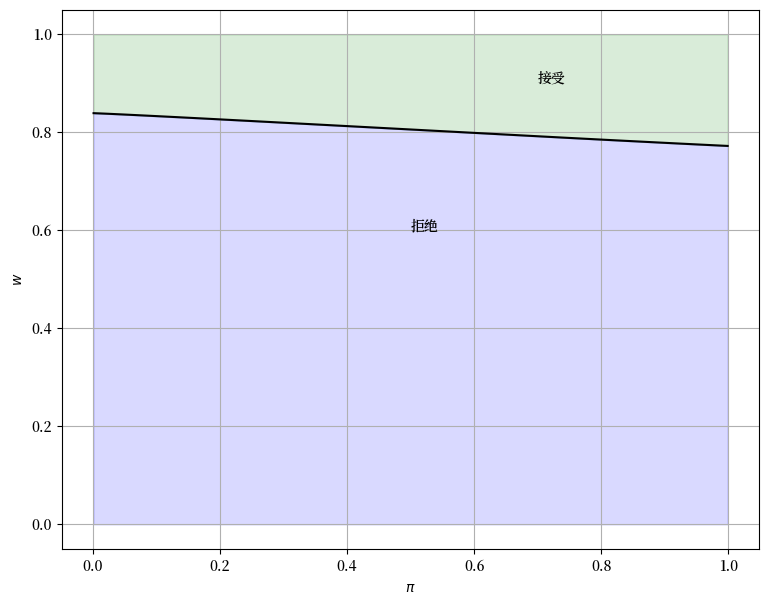

In [11]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
ax.text(0.5, 0.6, '拒绝')
ax.text(0.7, 0.9, '接受')
ax.set(xlabel=r'$\pi$', ylabel='$w$')
ax.grid()
plt.show()

```{solution-end}
```

## 附录A

下面这段代码生成了一个有趣的模拟,用来观察失业率受底层分布变化的影响。

在模拟的某个时点,分布发生了显著恶化。

代理人需要一段时间才能意识到这一点,在此期间,他们过于乐观并拒绝了太多工作机会。

结果导致失业率激增。

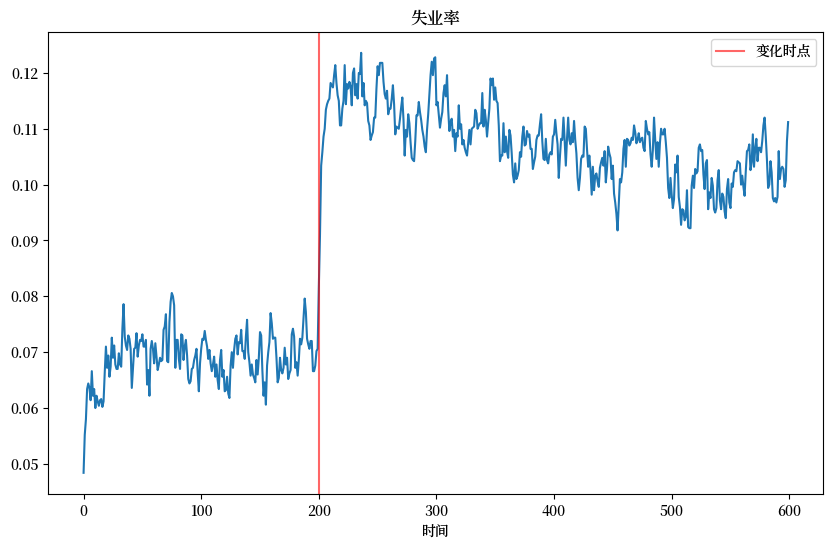

In [12]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# 求解保留工资
w_bar = solve_wbar(sp, verbose=False)

# 插值保留工资函数
π_grid = sp.π_grid
w_func = jit(lambda x: np.interp(x, π_grid, w_bar))

@jit
def update(a, b, e, π):
    "通过从参数为a和b的beta分布中抽取工资报价来更新e和π"

    if e == False:
        w = np.random.beta(a, b)       # 随机抽取工资
        if w >= w_func(π):
            e = True                   # 接受新工作
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

    return e, π

@jit
def simulate_path(F_a=F_a,
                  F_b=F_b,
                  G_a=G_a,
                  G_b=G_b,
                  N=5000,       # 代理人数量
                  T=600,        # 模拟长度
                  d=200,        # 变化时点
                  s=0.025):     # 分离率

    """模拟N个劳动者在T个时期的就业路径"""

    e = np.ones((N, T+1))
    π = np.full((N, T+1), 1e-3)

    a, b = G_a, G_b   # 初始分布参数

    for t in range(T+1):

        if t == d:
            a, b = F_a, F_b  # 改变分布参数

        # 更新每个代理人
        for n in range(N):
            if e[n, t] == 1:                    # 如果代理人当前就业
                p = np.random.uniform(0, 1)
                if p <= s:                      # 以概率s随机分离
                    e[n, t] = 0

            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π

    return e[:, 1:]

d = 200  # 在时点d改变分布
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemployment_rate)
ax.axvline(d, color='r', alpha=0.6, label='变化时点')
ax.set_xlabel('时间')
ax.set_title('失业率')
ax.legend()
plt.show()

## 附录B

在本附录中，我们将详细说明贝叶斯定律如何影响模型的运作。

我们展示一些图表，以带来关于学习如何运作的额外见解。

我们基于[这个讲座](https://python.quantecon.org/exchangeable.html)中提出的图表进行扩展。

特别是，我们将在该讲座中展示的关键图表中加入求职者的行为。

首先，我们定义两个函数来计算失业持续时间和就业时π的经验分布。

In [13]:
@jit
def empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid,
                   N=10000, T=600):
    """
    模拟人群以计算失业持续时间的经验累积分布和劳动者接受工资报价时的π值。
    对于每个求职问题，我们模拟两种情况：f或g是真实的报价分布。

    参数
    ----------

    F_a, F_b, G_a, G_b : beta分布F和G的参数
    w_bar : 保留工资
    π_grid : π的网格点，用于插值
    N : 模拟的劳动者数量，可选
    T : 模拟的最大时间段，可选

    返回值
    -------
    accpet_t : 2 x N ndarray。当f或g生成报价时的失业持续时间的经验分布。
    accept_π : 2 x N ndarray。当f或g生成报价时就业时π的经验分布。
    """

    accept_t = np.empty((2, N))
    accept_π = np.empty((2, N))

    # f或g生成报价
    for i, (a, b) in enumerate([(F_a, F_b), (G_a, G_b)]):
        # 更新每个代理
        for n in range(N):

            # 初始先验
            π = 0.5

            for t in range(T+1):

                # 抽取随机工资
                w = np.random.beta(a, b)
                lw = p(w, F_a, F_b) / p(w, G_a, G_b)
                π = π * lw / (π * lw + 1 - π)

                # 如果接受则移至下一个代理
                if w >= np.interp(π, π_grid, w_bar):
                    break

            # 记录失业持续时间
            # 和接受时的π值
            accept_t[i, n] = t
            accept_π[i, n] = π

    return accept_t, accept_π

def cumfreq_x(res):
    """
    用于计算累积频率直方图的x网格的辅助函数。
    """

    cumcount = res.cumcount
    lowerlimit, binsize = res.lowerlimit, res.binsize

    x = lowerlimit + np.linspace(0, binsize*cumcount.size, cumcount.size)

    return x

现在我们定义一个包装函数，用于分析不同参数化条件下带有学习的工作搜索模型。

这个包装函数接收贝塔分布的参数和失业补偿作为输入，然后显示我们想要了解的各种信息，以解释我们搜索模型的解。

此外，它还计算两个关键对象的经验累积分布。

In [14]:
def job_search_example(F_a=1, F_b=1, G_a=3, G_b=1.2, c=0.3):
    """
    给定指定F和G分布的参数，
    计算并显示拒绝和接受区域，
    信念π的演变，以及在不同π水平下接受offer的概率，
    并模拟计算失业持续时间的经验累积分布，
    以及劳动者接受offer时π的经验累积分布。
    """

    # 构建搜索问题
    sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b, c=c)
    f, g = sp.f, sp.g
    π_grid = sp.π_grid

    # 求解保留工资
    w_bar = solve_wbar(sp, verbose=False)

    # l(w) = f(w) / g(w)
    l = lambda w: f(w) / g(w)
    # 求解l(w) = 1的目标函数
    obj = lambda w: l(w) - 1.

    # 贝塔分布的众数
    # 用它将w分成两个区间进行根查找
    G_mode = (G_a - 1) / (G_a + G_b - 2)
    roots = np.empty(2)
    roots[0] = op.root_scalar(obj, bracket=[1e-10, G_mode]).root
    roots[1] = op.root_scalar(obj, bracket=[G_mode, 1-1e-10]).root

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    # 第1部分：显示模型设置的细节和一些结果
    w_grid = np.linspace(1e-12, 1-1e-12, 100)

    axs[0, 0].plot(l(w_grid), w_grid, label='$l$', lw=2)
    axs[0, 0].vlines(1., 0., 1., linestyle="--")
    axs[0, 0].hlines(roots, 0., 2., linestyle="--")
    axs[0, 0].set_xlim([0., 2.])
    axs[0, 0].legend(loc=4)
    axs[0, 0].set(xlabel='$l(w)=f(w)/g(w)$', ylabel='$w$')

    axs[0, 1].plot(sp.π_grid, w_bar, color='k')
    axs[0, 1].fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
    axs[0, 1].fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
    axs[0, 1].text(0.5, 0.6, '拒绝')
    axs[0, 1].text(0.7, 0.9, '接受')

    W = np.arange(0.01, 0.99, 0.08)
    Π = np.arange(0.01, 0.99, 0.08)

    ΔW = np.zeros((len(W), len(Π)))
    ΔΠ = np.empty((len(W), len(Π)))
    for i, w in enumerate(W):
        for j, π in enumerate(Π):
            lw = l(w)
            ΔΠ[i, j] = π * (lw / (π * lw + 1 - π) - 1)

    q = axs[0, 1].quiver(Π, W, ΔΠ, ΔW, scale=2, color='r', alpha=0.8)

    axs[0, 1].hlines(roots, 0., 1., linestyle="--")
    axs[0, 1].set(xlabel=r'$\pi$', ylabel='$w$')
    axs[0, 1].grid()

    axs[1, 0].plot(f(x_grid), x_grid, label='$f$', lw=2)
    axs[1, 0].plot(g(x_grid), x_grid, label='$g$', lw=2)
    axs[1, 0].vlines(1., 0., 1., linestyle="--")
    axs[1, 0].hlines(roots, 0., 2., linestyle="--")
    axs[1, 0].legend(loc=4)
    axs[1, 0].set(xlabel='$f(w), g(w)$', ylabel='$w$')

    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, F_a, F_b), label='$f$')
    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, G_a, G_b), label='$g$')
    axs[1, 1].set_ylim([0., 1.])
    axs[1, 1].grid()
    axs[1, 1].legend(loc=4)
    axs[1, 1].set(xlabel=r'$\pi$', ylabel=r'$\mathbb{P}\{w > \overline{w} (\pi)\}$')

    plt.show()

    # 第2部分：模拟经验累积分布
    accept_t, accept_π = empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid)
    N = accept_t.shape[1]

    cfq_t_F = cumfreq(accept_t[0, :], numbins=100)
    cfq_π_F = cumfreq(accept_π[0, :], numbins=100)

    cfq_t_G = cumfreq(accept_t[1, :], numbins=100)
    cfq_π_G = cumfreq(accept_π[1, :], numbins=100)

    fig, axs = plt.subplots(2, 1, figsize=(12, 9))

    axs[0].plot(cumfreq_x(cfq_t_F), cfq_t_F.cumcount/N, label="f生成")
    axs[0].plot(cumfreq_x(cfq_t_G), cfq_t_G.cumcount/N, label="g生成")
    axs[0].grid(linestyle='--')
    axs[0].legend(loc=4)
    axs[0].title.set_text('失业持续时间的CDF')
    axs[0].set(xlabel='时间', ylabel='概率(时间)')

    axs[1].plot(cumfreq_x(cfq_π_F), cfq_π_F.cumcount/N, label="f生成")
    axs[1].plot(cumfreq_x(cfq_π_G), cfq_π_G.cumcount/N, label="g生成")
    axs[1].grid(linestyle='--')
    axs[1].legend(loc=4)
    axs[1].title.set_text('劳动者接受工资并离开失业状态时π的CDF')
    axs[1].set(xlabel='π', ylabel='概率(π)')

    plt.show()

我们现在提供一些示例，帮助理解模型的工作原理。

## 示例

### 示例1（基准）

$F$ ~ Beta(1, 1), $G$ ~ Beta(3, 1.2), $c$=0.3.

在下面的图中，右上图中的红色箭头显示了$\pi_t$如何根据新信息$w_t$进行更新。

回顾[本讲](https://python.quantecon.org/exchangeable.html)中的以下公式

$$
\frac{\pi_{t+1}}{\pi_{t}}=\frac{l\left(w_{t+1}\right)}{\pi_{t}l\left(w_{t+1}\right)+\left(1-\pi_{t}\right)}\begin{cases}
>1 & \text{if }l\left(w_{t+1}\right)>1\\
\leq1 & \text{if }l\left(w_{t+1}\right)\leq1
\end{cases}
$$

该公式表明$\pi_t$的变动方向取决于$l(w_t)$与1之间的关系。

变动幅度在以下情况下会很小：

- 当$l(w)$接近1时，这意味着新的$w$对区分两个分布的信息量不大
- 当$\pi_{t-1}$接近0或1时，这意味着先验很强

当实际的分布是 $g$ 而不是 $f$ 时，失业劳动者会更早接受工作机会还是不会？

这里存在两个相互抵消的效应。

- 如果 $f$ 产生连续的工资报价，那么 $w$ 更可能偏低，但 $\pi$ 会向 1 移动，这会降低保留工资，
  也就是说，劳动者失业时间越长就越不挑剔。
- 如果 $g$ 产生工资报价，那么 $w$ 更可能偏高，但 $\pi$ 会向 0 移动，这会提高保留工资，也就是说，劳动者失业时间越长就越挑剔。

从定量角度来看，右下图说明了在这个例子中哪个效应占主导地位。

它显示了当 $f$ 或 $g$ 产生工资报价时，之前失业的劳动者在不同 $\pi$ 值下接受工作机会的概率。

该图表明，对于这个例子中特定的 $f$ 和 $g$，

即使当 $\pi$ 接近零时，当 $f$ 生成数据时，劳动者也更有可能接受offer，尽管此时劳动者相信真实分布是 $g$ 并因此相对更具选择性。

失业持续时间的经验累积分布验证了我们的推测。

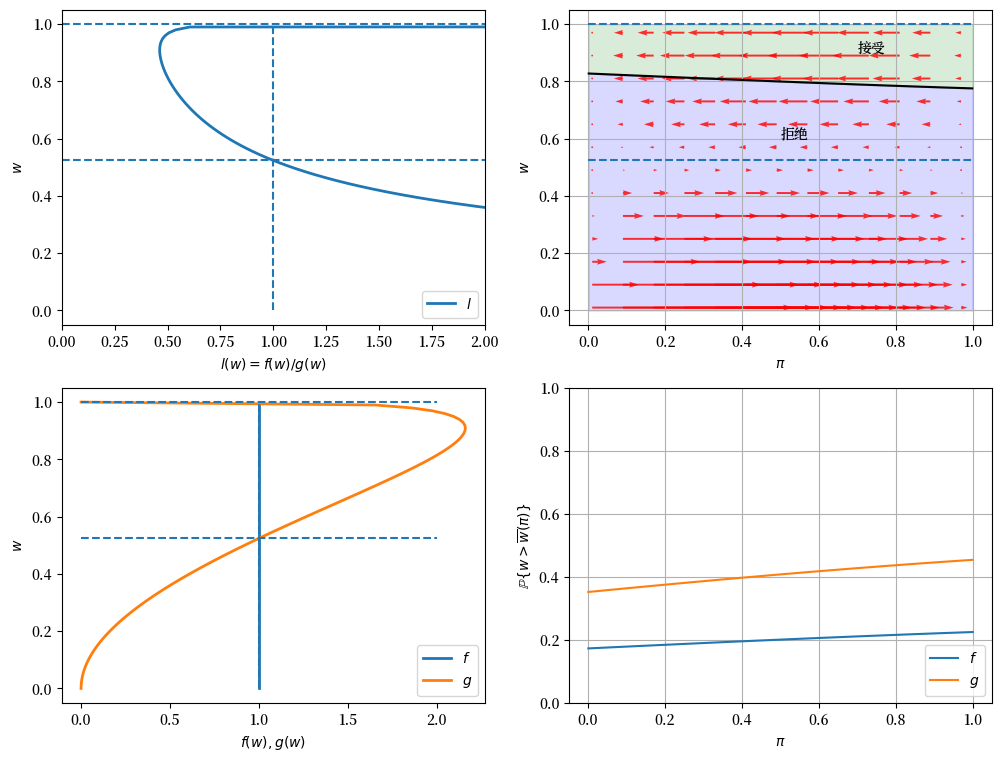

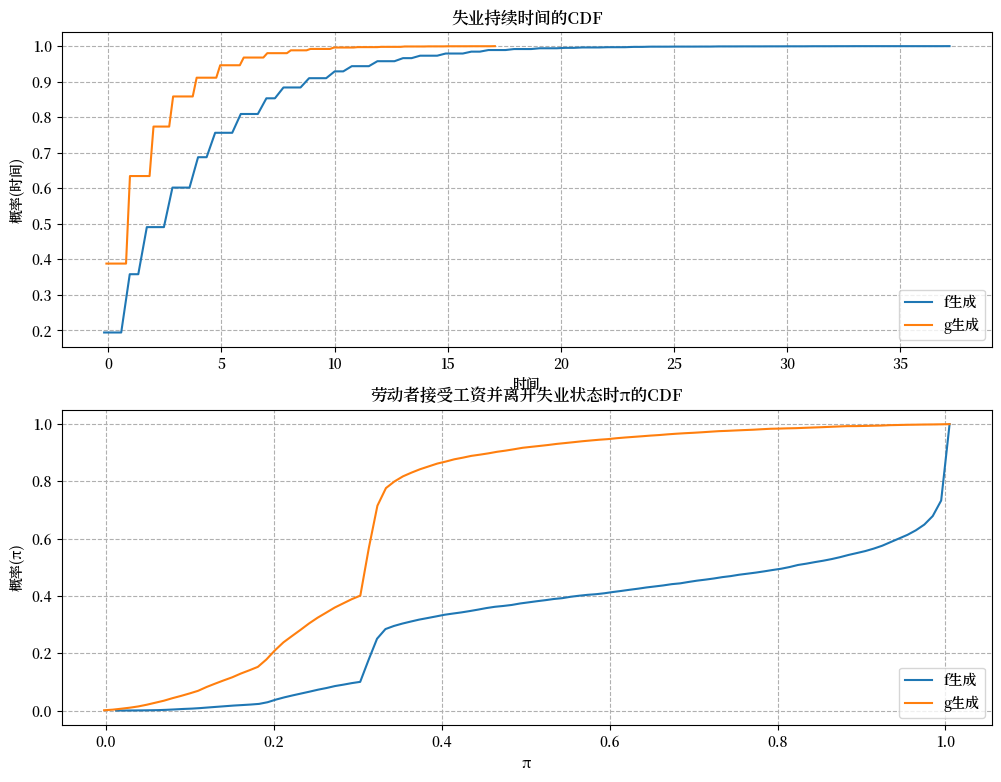

In [15]:
job_search_example()

### 示例 2

$F$ ~ Beta(1, 1), $G$ ~ Beta(1.2, 1.2), $c$=0.3。

现在$G$与$F$具有相同的均值但方差更小。

由于失业补助金$c$作为不良工资报价的下限，$G$现在是相对于$F$的一个"劣等"分布。

因此，我们观察到最优策略$\overline{w}(\pi)$随$\pi$增加而增加。

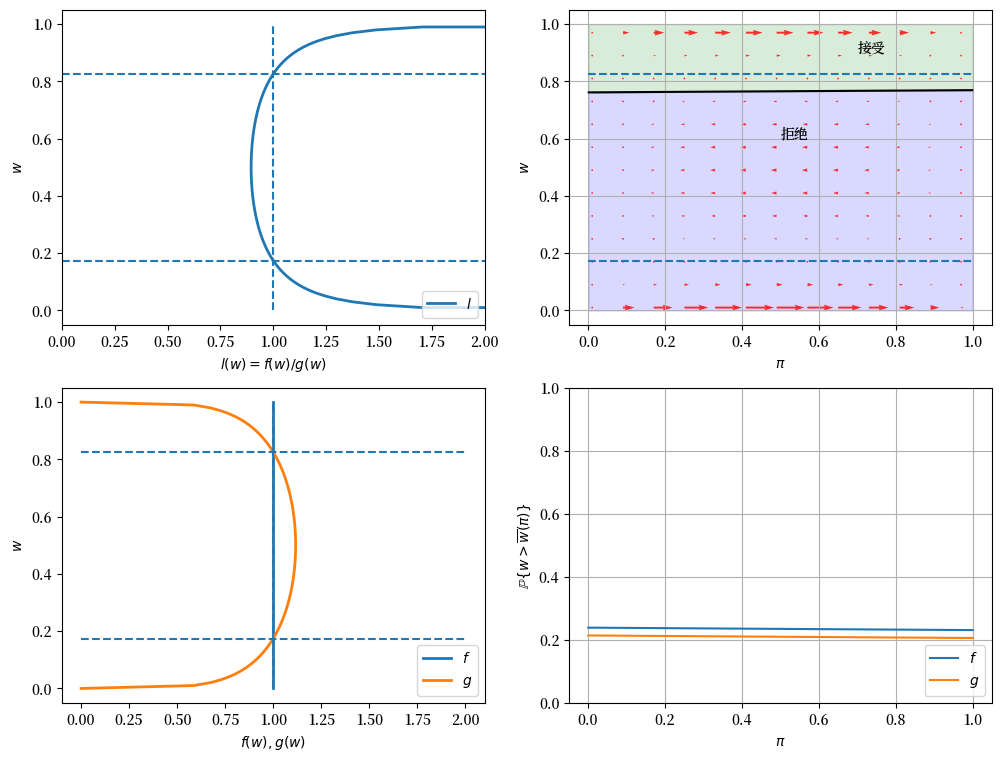

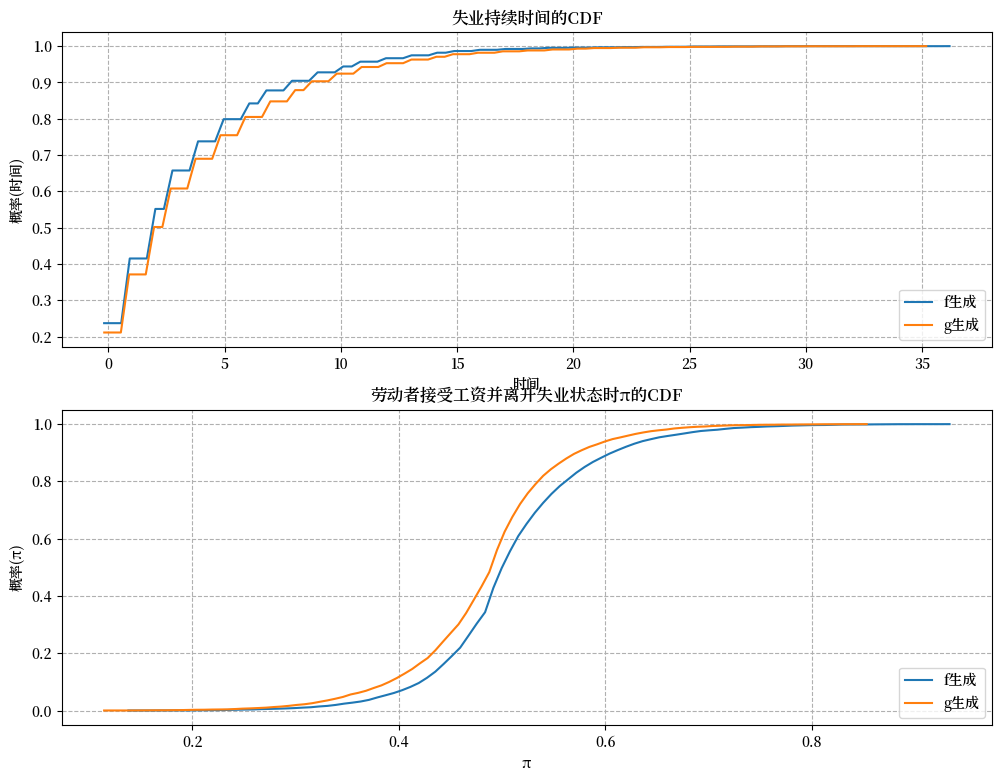

In [16]:
job_search_example(1, 1, 1.2, 1.2, 0.3)

### 示例 3

$F$ ~ Beta(1, 1), $G$ ~ Beta(2, 2), $c$=0.3.

如果$G$的方差更小，我们在结果中观察到$G$甚至更加"劣势"，且$\overline{w}(\pi)$的斜率更大。

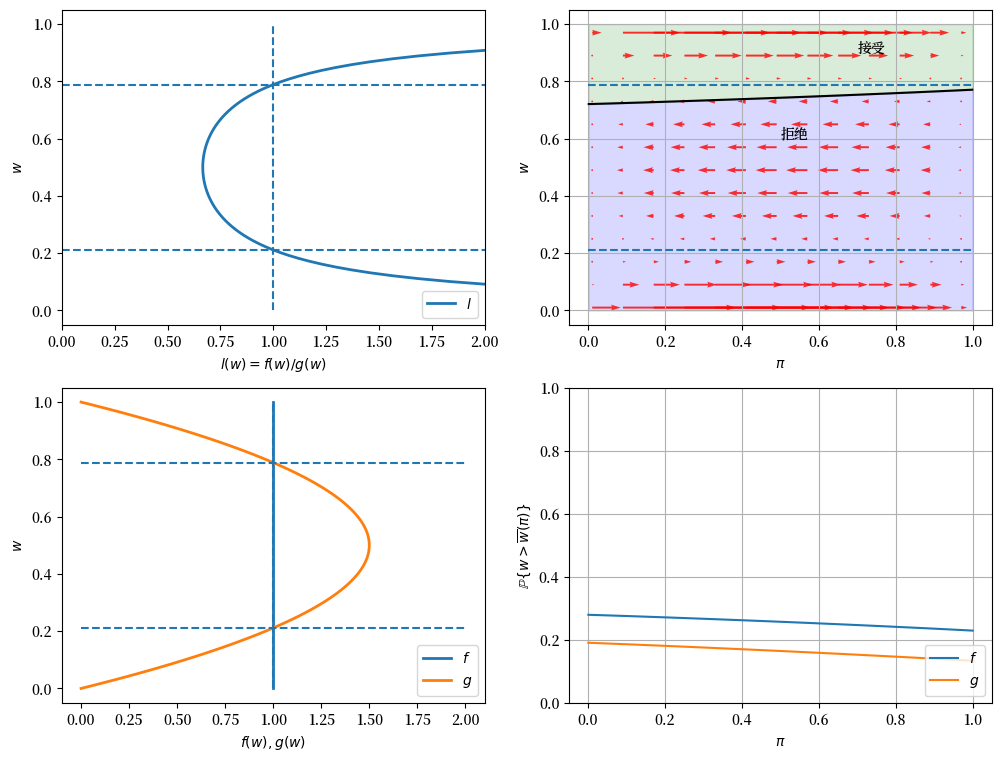

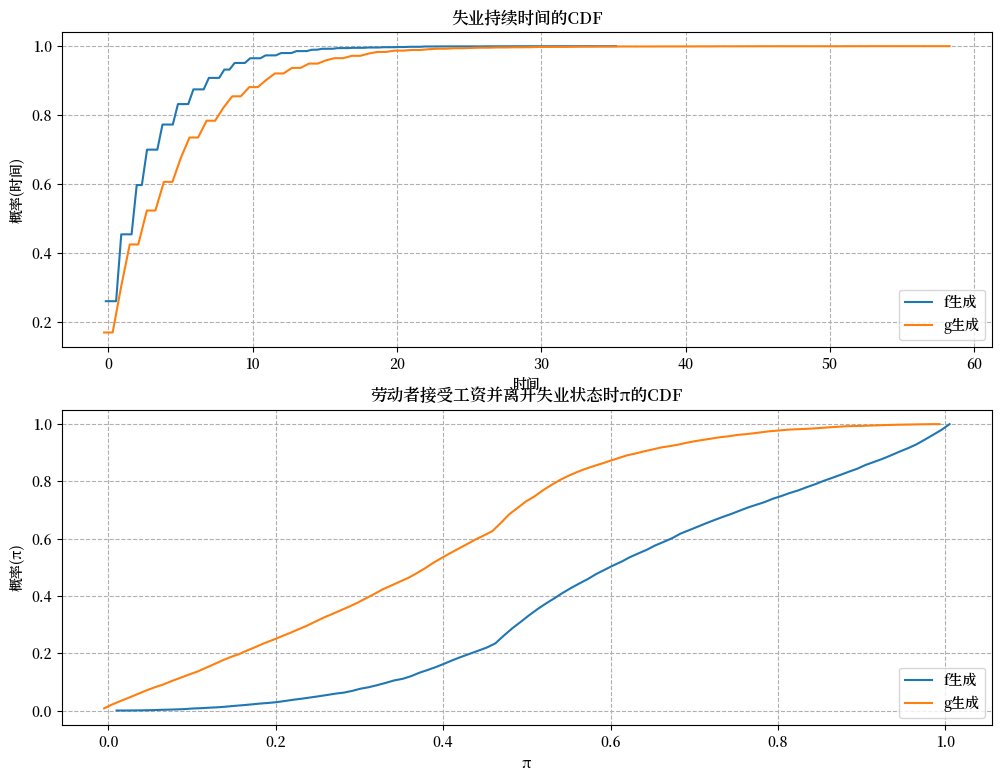

In [17]:
job_search_example(1, 1, 2, 2, 0.3)

### 示例 4

$F$ ~ Beta(1, 1)，$G$ ~ Beta(3, 1.2)，且 $c$=0.8。

在这个示例中，我们保持贝塔分布的参数与基准情况相同，但增加了失业补助金 $c$。

与基准情况（示例1）相比，在失业补助金较低（$c$=0.3）的情况下，现在劳动者可以承担更长的学习期。

因此，劳动者倾向于更晚接受工资报价。

此外，在接受就业时，信念 $\pi$ 更接近于 0 或 1。

这意味着当劳动者最终选择接受工资报价时，他对真实分布有了更好的认识。

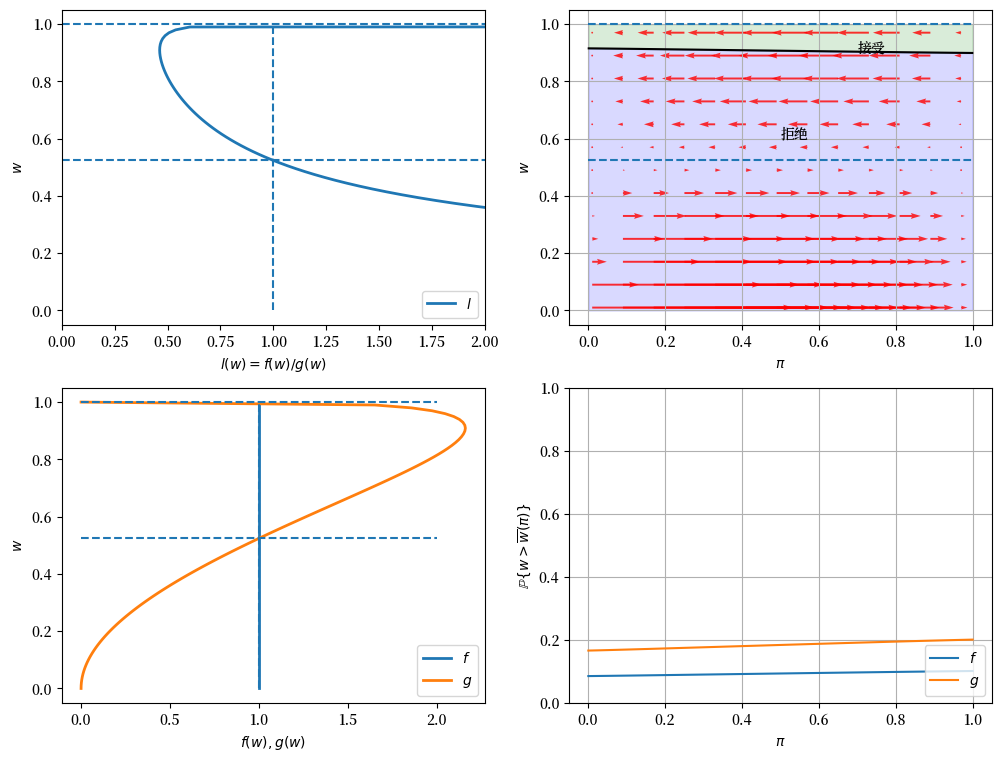

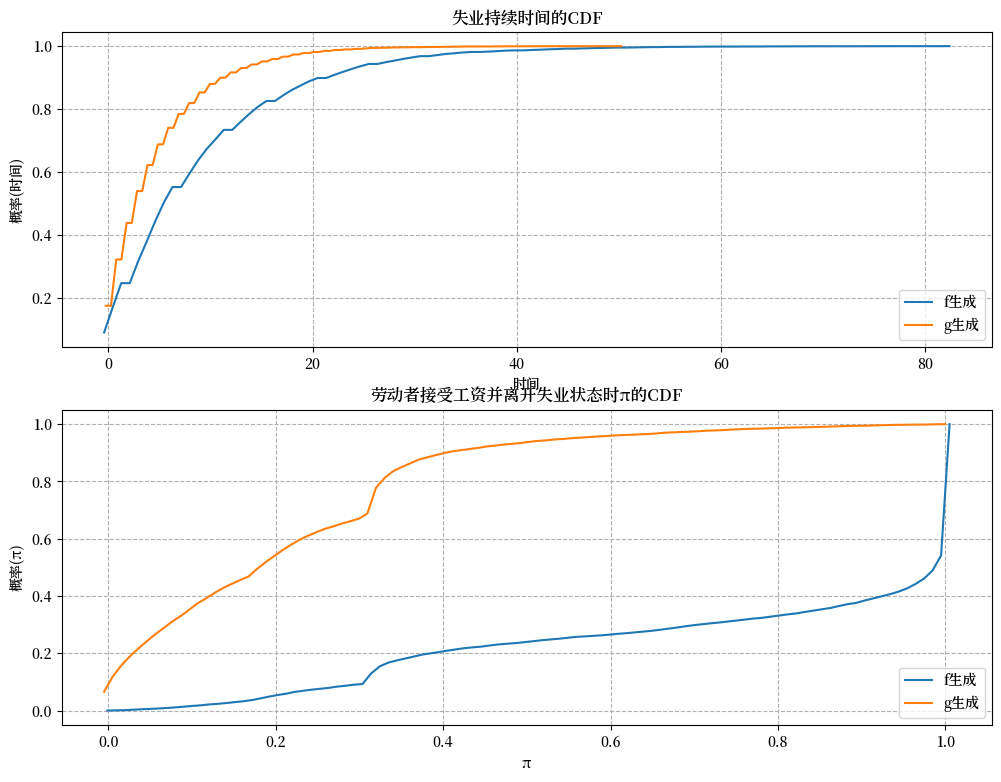

In [18]:
job_search_example(1, 1, 3, 1.2, c=0.8)

### 示例 5

$F$ ~ Beta(1, 1), $G$ ~ Beta(3, 1.2), 且 $c$=0.1。

正如预期的那样，较小的 $c$ 使失业劳动者在获取较少的工资分布信息后就更早地接受工资offer。

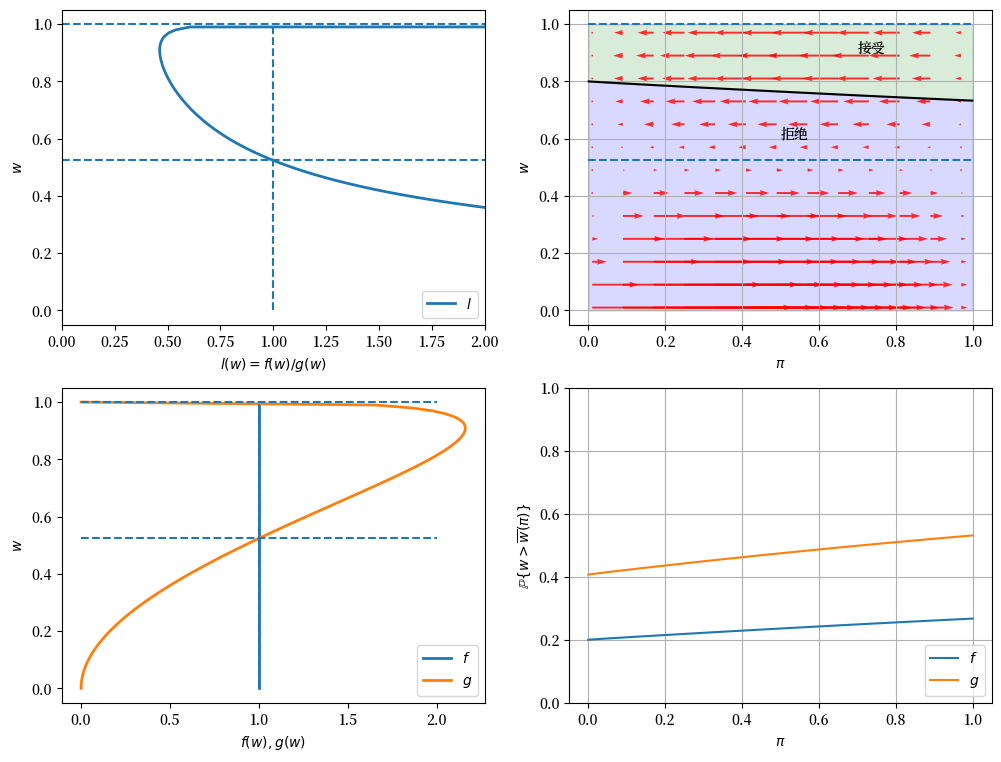

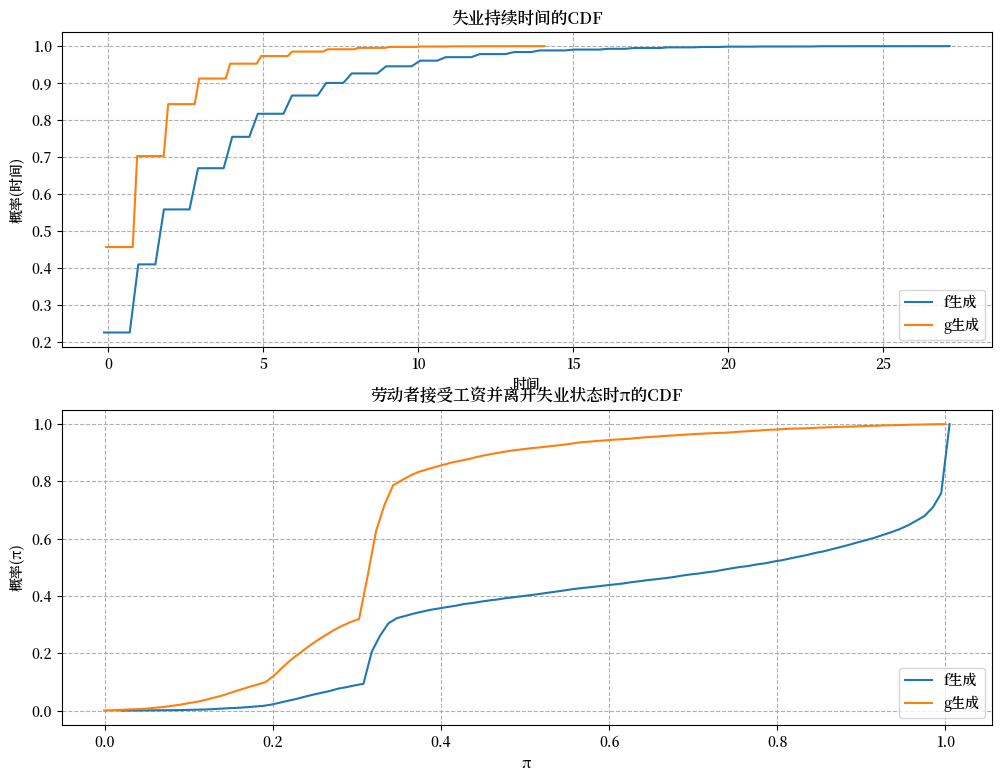

In [19]:
job_search_example(1, 1, 3, 1.2, c=0.1)